In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import numpy as np
import torch
from typing import Optional, Sequence

# -----------------------------
# 设置中文字体
# -----------------------------
# Windows 系统可用 "SimHei"（黑体）
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  
# 避免负号显示为方块
matplotlib.rcParams['axes.unicode_minus'] = False

In [4]:


class BinaryBTSPNetworkTorch:
    """二值 BTSP 网络（CA3 -> CA1），使用 PyTorch 加速"""
    def __init__(
        self,
        n_input: int,
        n_memory: int,
        weight_density: float = 0.01,
        threshold: Optional[Sequence[int]] = None,
        device: Optional[str] = None,
    ):
        self.device = torch.device(device or ("cuda" if torch.cuda.is_available() else "cpu"))
        self.n_input = n_input
        self.n_memory = n_memory

        # 随机初始化二值权重
        self.weights = (torch.rand(n_memory, n_input, device=self.device) < weight_density).to(torch.uint8)

        # 阈值
        if threshold is None:
            incoming = self.weights.sum(dim=1)
            thr = (incoming.float() / 2).ceil().to(torch.int)
            thr[thr < 1] = 1
            self.threshold = thr
        else:
            thr = torch.tensor(threshold, device=self.device, dtype=torch.int)
            if thr.shape == ():
                thr = thr.repeat(n_memory)
            self.threshold = thr

    def forward(self, input_pattern: Sequence[int]) -> torch.Tensor:
        """前向传播"""
        x = torch.as_tensor(input_pattern, dtype=torch.uint8, device=self.device)
        if x.shape != (self.n_input,):
            raise ValueError(f"input_pattern must have shape ({self.n_input},), got {x.shape}")
        summed = torch.matmul(self.weights.float(), x.float())  # shape: (n_memory,)
        out = (summed >= self.threshold).to(torch.uint8)
        return out

    def btsp_update(self, input_pattern: Sequence[int]) -> None:
        """BTSP 更新（概率翻转 0/1 突触）"""
        x = torch.as_tensor(input_pattern, dtype=torch.uint8, device=self.device)
        active_idx = torch.nonzero(x, as_tuple=True)[0]
        if active_idx.numel() == 0:
            return
        flips = (torch.rand(self.n_memory, active_idx.numel(), device=self.device) < 0.005).to(torch.uint8)
        sub = self.weights[:, active_idx]
        self.weights[:, active_idx] = sub ^ flips  # XOR 翻转

    def train(self, patterns: Sequence[Sequence[int]]) -> None:
        """训练多个模式"""
        for pat in patterns:
            self.btsp_update(pat)

    @staticmethod
    def make_sparse_patterns(n_patterns: int, n_input: int, sparsity: float, device: Optional[str] = None) -> torch.Tensor:
        """生成稀疏二值输入模式矩阵"""
        if not (0.0 < sparsity <= 1.0):
            raise ValueError("sparsity must be in (0, 1]")
        device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        return (torch.rand(n_patterns, n_input, device=device) < sparsity).to(torch.uint8)

    def compute_relative_dissimilarity(
        self,
        patterns: torch.Tensor,
        mask_ratios: Sequence[float],
        n_repeats: int = 10,
        eps: float = 1e-8,
    ) -> np.ndarray:
        """
        计算不同掩码比例下的平均相对不相似度
        patterns: (n_patterns, n_input) 二值张量
        mask_ratios: 掩码比例数组，如 [0, 0.1, 0.2, ...]
        n_repeats: 重复次数
        返回: (len(mask_ratios),) 的 numpy 数组
        """
        patterns = patterns.to(self.device)
        n_patterns = patterns.shape[0]

        mean_rel_diss = []
        for mask_ratio in mask_ratios:
            rel_diss_list = []
            for _ in range(n_repeats):
                for idx in range(n_patterns):
                    pattern = patterns[idx]
                    z_orig = self.forward(pattern)

                    # 构造掩码
                    n_mask = int(mask_ratio * pattern.numel())
                    mask = torch.ones_like(pattern)
                    if n_mask > 0:
                        mask_idx = torch.randperm(pattern.numel(), device=self.device)[:n_mask]
                        mask[mask_idx] = 0
                    pattern_masked = pattern * mask
                    z_masked = self.forward(pattern_masked)

                    # 随机挑选另一个 pattern
                    if n_patterns > 1:
                        rand_idx = torch.randint(0, n_patterns - 1, (1,), device=self.device).item()
                        if rand_idx >= idx:
                            rand_idx += 1  # 避免等于自己
                        pattern_rand = patterns[rand_idx]
                    else:
                        pattern_rand = torch.zeros_like(pattern)

                    z_rand = self.forward(pattern_rand)

                    # 归一化海明距离
                    hd_same = (z_orig != z_masked).float().mean().item()
                    hd_rand = (z_orig != z_rand).float().mean().item()
                    rel = hd_same / (hd_rand + eps)
                    rel_diss_list.append(rel)

            mean_rel_diss.append(np.mean(rel_diss_list))

        return np.array(mean_rel_diss)


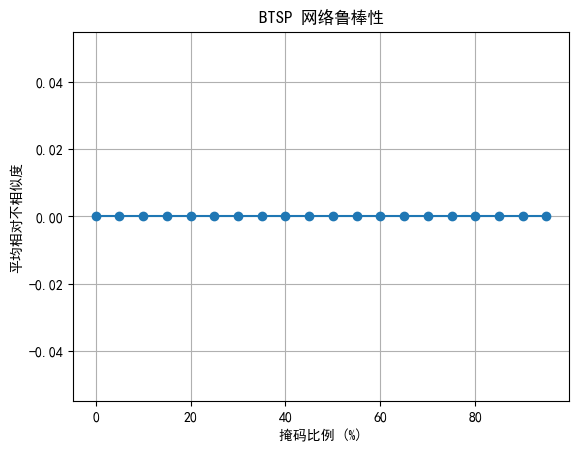

In [5]:
# 参数
n_input = 2000
n_memory = 3000
sparsity = 0.0025
mask_ratios = np.arange(0, 1.00, 0.05)

# 初始化网络 & 生成模式
net = BinaryBTSPNetworkTorch(n_input, n_memory)
patterns = BinaryBTSPNetworkTorch.make_sparse_patterns(30, n_input, sparsity)

# 训练
net.train(patterns)

# 计算鲁棒性
mean_rel_diss = net.compute_relative_dissimilarity(patterns, mask_ratios, n_repeats=5)

# 绘图
import matplotlib.pyplot as plt
plt.plot(mask_ratios*100, mean_rel_diss, marker='o')
plt.xlabel("掩码比例 (%)")
plt.ylabel("平均相对不相似度")
plt.title("BTSP 网络鲁棒性")
plt.grid(True)
plt.show()



In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

import matplotlib.pyplot as plt

# 假设 net 是 BinaryBTSPNetworkTorch 已训练好
device = net.device
net.weights = net.weights.to(device)  # 确保权重在 GPU

mask_ratios = np.arange(0, 1.0, 0.05)
n_repeats = 5
mean_overlaps = []

# 将训练好的模式从 GPU 转回 CPU 进行掩码处理，减小显存压力
patterns_cpu = patterns_torch.cpu()

for mask_ratio in mask_ratios:
    overlaps = []
    for _ in range(n_repeats):
        for pattern in patterns_cpu:
            # 前向传播使用 GPU
            ca1_original = net.forward(pattern.to(device)).cpu()

            # 构造掩码（CPU 上）
            mask = np.ones_like(pattern.numpy(), dtype=np.uint8)
            n_mask = int(mask_ratio * pattern.numel())
            if n_mask > 0:
                mask_indices = np.random.choice(pattern.numel(), size=n_mask, replace=False)
                mask[mask_indices] = 0

            masked_input = pattern.numpy() * mask
            masked_input_tensor = torch.tensor(masked_input, dtype=torch.uint8, device=device)

            # 前向传播
            ca1_masked = net.forward(masked_input_tensor).cpu()

            # 计算相同位比例
            overlap_ratio = (ca1_original == ca1_masked).float().mean().item()
            overlaps.append(overlap_ratio)

    mean_overlap = np.mean(overlaps)
    mean_overlaps.append(mean_overlap)
    print(f"掩码比例 {mask_ratio*100:.0f}%: 平均记忆回想相同位比例 = {mean_overlap:.4f}")

# 绘图
plt.figure(figsize=(6, 4))
plt.plot(mask_ratios*100, mean_overlaps, marker='o', linestyle='-', color='b')
plt.xlabel("掩码比例 (%)")
plt.ylabel("平均记忆回想相同位比例")
plt.title("BTSP 网络记忆鲁棒性随掩码比例变化")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


NameError: name 'patterns_torch' is not defined

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import plotly.graph_objects as go




n_input = 2000
n_memory = 3000
mask_ratios = np.arange(0, 1.0, 0.05)
n_memories_list = [0,n_memory,int(0.05*n_memory)]  # 可调整

performance = np.zeros((len(n_memories_list), len(mask_ratios)))

for i, n_memories in enumerate(n_memories_list):
    # 生成 n_memories 条随机稀疏模式
    n_active = int(n_input * 0.0025)  # 每个模式激活的神经元数
    patterns = np.zeros((n_memories, n_input), dtype=np.uint8)

    for k in range(n_memories):
        idx = np.random.choice(n_input, n_active, replace=False)
        patterns[k, idx] = 1

    
    # 初始化网络
    net = BinaryBTSPNetworkTorch(n_input, n_memory, device=device)
    net.train(patterns_torch)

    for j, mask_ratio in enumerate(mask_ratios):
        overlaps = []
        for pattern in patterns_torch.cpu():  # CPU 循环掩码
            ca1_original = net.forward(pattern.to(device)).cpu()
            # 构造掩码
            mask = np.ones_like(pattern.numpy(), dtype=np.uint8)
            n_mask = int(mask_ratio * n_input)
            if n_mask > 0:
                mask_indices = np.random.choice(n_input, size=n_mask, replace=False)
                mask[mask_indices] = 0
            masked_input = pattern.numpy() * mask
            masked_input_tensor = torch.tensor(masked_input, dtype=torch.uint8, device=device)
            ca1_masked = net.forward(masked_input_tensor).cpu()
            overlap_ratio = (ca1_original == ca1_masked).float().mean().item()
            overlaps.append(overlap_ratio)
        performance[i, j] = np.mean(overlaps)

# 绘制 3D 曲面图
from mpl_toolkits.mplot3d import Axes3D

X, Y = np.meshgrid(mask_ratios*100, n_memories_list)
Z = performance






# 假设 X, Y, Z 都是 numpy 数组
fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y)])
fig.update_layout(
    scene=dict(
        xaxis_title='掩码比例 (%)',
        yaxis_title='记忆数量',
        zaxis_title='平均回想相同位比例'
    ),
    title='BTSP 网络回想性能',
    width=900,
    height=700,
    margin=dict(l=50, r=50, b=120, t=100)  # 保证底部不被挡
)
fig.show()

NameError: name 'patterns_torch' is not defined